Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "SIDDHARTH YASHASWEE"
COLLABORATORS = ""

---

# Clustering
In this notebook you will implement different methods for k-means clustering and expectation maximization on Gaussian mixture models. The imported libraries below are sufficient to solve the tasks. You are not allowed to use any additional libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
np.random.seed(42)

## The data
This is the data that we will test your implementations on:

In [3]:
clustering_data = np.load("clustering_data.npz")
blobs = clustering_data["blobs"]
varied = clustering_data["varied"]
aniso = clustering_data["aniso"]
circles = clustering_data["circles"]
moons = clustering_data["moons"]
datasets = [blobs, varied, aniso, circles, moons]

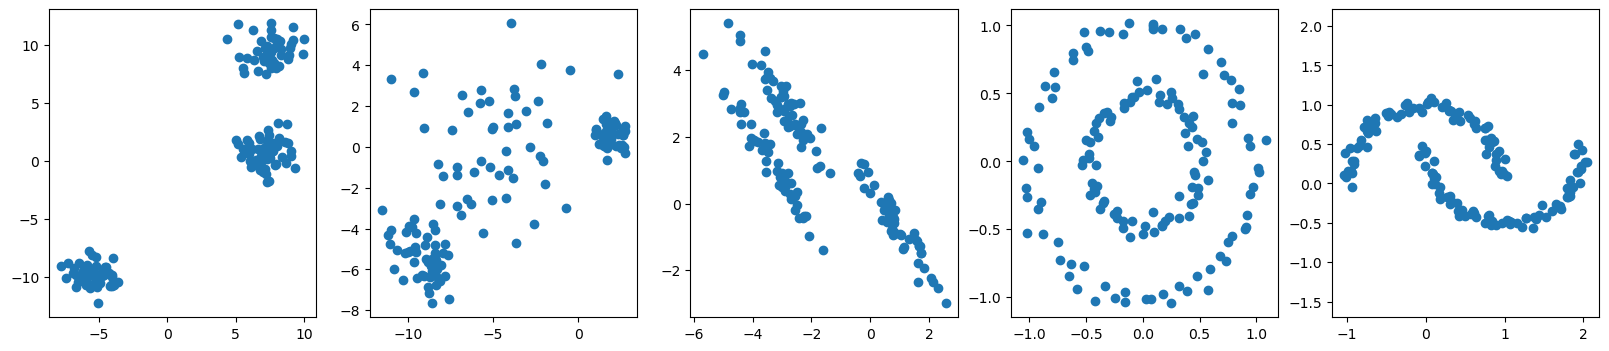

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
for ax, data in zip(axes, datasets):
    ax.scatter(data[:,0], data[:,1])
    plt.axis('equal')

## K-Means
For k-means you are required to implement the `assign` and the `update` methods. Each cluster is represented as a dictionary with 2 keywords, namely `mean` (which holds the corresponding 2D mean vector for each cluster) and `indices` (which is a list of indices of data points assigned to the cluster). The `run` method alternates between calling the `assign` and the `update` functions and stops once the maximum number of iterations is reached or the quality of the clustering hasn't changed. In the `assign` method you should compute the new `indices` for each cluster. In `update` you have to compute the new `mean` for each cluster.

In order to debug your implementation it is helpful to use `plot_clusters` to visualize the current state. The means are displayed as crosses and if the list in `indices` isn't empty you will see points visualized in different colors according to their assignment to the various clusters.

In [5]:
class KMeans:
    def __init__(self, data, k):
        self.data = data
        self.k = k
        self.cluster = [dict() for _ in range(k)]
        self.init()
    
    def init(self):
        choice = np.random.choice(self.data.shape[0])
        means = [self.data[choice]]
        for _ in range(self.k-1):
            dists = self.dists_to_means(means)
            probs = dists / dists.sum()
            choice = np.random.choice(self.data.shape[0], replace=False, p=probs)
            means.append(self.data[choice])
        for c,m in zip(self.cluster, means):
            c['mean'] = m
            c['indices'] = []
        
    def run(self, max_iter):
        last_quality = np.inf
        for _ in range(max_iter):
            self.assign()
            self.update()
            q = self.quality()
            if np.abs(q-last_quality) < 1e-3:
                break
            last_quality = q
        
    def assign(self):
        ### YOUR CODE HERE
        
        #list saying what cluster index a point belongs to
        for cluster in self.cluster:
                cluster["indices"]=[]
        
        #loop to assign datapoints to cluster one by one
        for idx, x in enumerate(self.data): 
        
            #store distance of datapoint from each cluster mean
            distance = []
            
            #loop to find distance of datapoint from each cluster mean 
            for cluster in self.cluster:
                distance.append(np.linalg.norm(cluster["mean"]-x))
                            
            #add data point index to cluster with the min distance from mean
            self.cluster[distance.index(min(distance))]["indices"].append(idx)
            
    def update(self):
        ### YOUR CODE HERE
        #adjust means for each cluster
        for cluster in self.cluster:
            #extract all points in the cluster
            assigned_points = self.data[cluster['indices']]
            #update the cluster mean
            cluster["mean"]=np.mean(assigned_points, axis=0)    
            
    def quality(self):
        mean_dist = 0.
        for c in self.cluster:
            if len(c['indices']) == 0:
                continue
            assigned_points = self.data[c['indices']]
            dists = (assigned_points - c['mean'])**2
            mean_dist += dists.mean()
        return mean_dist
    
    def dists_to_means(self, means):
        min_dists = np.ones(self.data.shape[0])
        for m in means:
            dists = np.linalg.norm((self.data - m)**2, axis=1)
            min_dists = np.minimum(dists, min_dists)
            
        return min_dists
    
    def plot_clusters(self):
        fig = plt.figure(figsize=(10,10))
        plt.scatter(self.data[:,0], self.data[:,1])
        for c in self.cluster:
            assigned_points = self.data[c['indices']]
            mean = c['mean']
            plt.scatter(assigned_points[:,0], assigned_points[:,1])
            plt.scatter(mean[0], mean[1], c='black', marker='+', s=500)
        plt.axis('equal')
        return

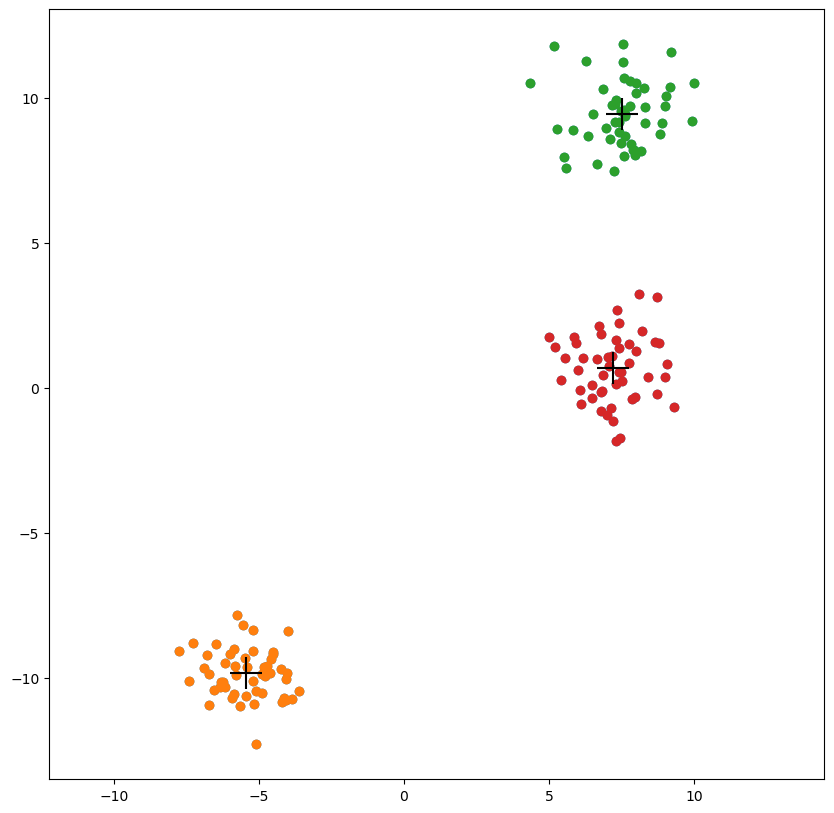

In [13]:
kmeans = KMeans(blobs, 3)
kmeans.run(200)
kmeans.plot_clusters()

In [7]:
kmeans = KMeans(blobs, 3)
kmeans.cluster[0]['mean'] = np.array([-5.,-10.])
kmeans.cluster[1]['mean'] = np.array([0.,0.])
kmeans.cluster[2]['mean'] = np.array([10.,10.])
kmeans.assign()
assert 2 in kmeans.cluster[0]['indices']
assert 149 in kmeans.cluster[1]['indices']
assert 30 in kmeans.cluster[2]['indices']

In [8]:
kmeans = KMeans(blobs, 3)
kmeans.cluster[0]['indices'] = [2,4,5,7]
kmeans.cluster[1]['indices'] = [1,6,8]
kmeans.cluster[2]['indices'] = [0,3,11,12,13]
kmeans.update()
assert np.allclose(kmeans.cluster[0]['mean'], np.array([-5.16960567, -10.11079982]))
assert np.allclose(kmeans.cluster[1]['mean'], np.array([8.02240741, 0.79977432]))
assert np.allclose(kmeans.cluster[2]['mean'], np.array([8.17635756, 7.76966255]))

## Expectation Maximization on GMMs
For this task you are to implement the `expectation` and `maximization` methods. Recall, that they correspond to the `assign` and `update` methods in k-means.

Each cluster is represented by a Gaussian distribution. Thus, our dictionary for each cluster has slightly different keywords to k-means. The 2D mean vectors are stored in `mean` as before. In addition we have a 2x2 covariance matrix stored in `cov` and a scalar weight `w`. As before the hard assignement of points to clusters is given with `indices`. The soft assignment from the GMMs can be turned into a hard one by calling `assign_points`. Here every point is assigned to the cluster with the highest assignment score.
Similar to k-means `run` alternates between calling the `expectation` and `maximization` functions until either the maximum number of iterations is reached or the log likelihood has not changed by a certain amount. The soft assignments `soft_assignment` ($\gamma$ in the lecture) are represented as a matrix where each row corresponds to each data point and each column corresponds to a Gaussian. The number of soft assigned points is given as a vector in `soft_n`, where `soft_n[i]` corresponds to the i-th Gaussian.

In `expectation` you will have to update `soft_assignment` and `soft_n`. To this end we have implemented the [bivariate Gaussian probability density function](https://www.wikiwand.com/en/Multivariate_normal_distribution#/Density_function) for your convenience in `bivariate_gaussian_pdf`. In `maximization` you have to update the `w`, `mean`, and `cov` parameters for each Gaussian/cluster. 

You can plot the current state with `plot_clusters`. The means are shown as crosses and the Gaussian distribution as ellipses. If you have called `assign_points` beforehand then the points will be visualized in different colours depending on their cluster membership.

In [9]:
class EM_GMMs:
    def __init__(self, data, k):
        self.data = data
        self.k = k
        self.cluster = [dict() for _ in range(k)]
        self.soft_assignment = np.ones((data.shape[0], k)) / k
        self.soft_n = self.soft_assignment.sum(0)
        self.init()
    
    def init(self):
        choice = np.random.choice(self.data.shape[0])
        means = [self.data[choice]]
        for _ in range(self.k-1):
            dists = self.dists_to_means(means)
            probs = dists / dists.sum()
            choice = np.random.choice(self.data.shape[0], replace=False, p=probs)
            means.append(self.data[choice])
        for c,m in zip(self.cluster, means):
            c['mean'] = m
            c['cov'] = np.identity(2)
            c['w'] = 1. / self.k
            c['indices'] = []
        
    def run(self, max_iter):
        last_ll = self.log_likelihood()
        for _ in range(max_iter):
            self.expectation()
            self.maximization()
            cur_ll = self.log_likelihood()
            if np.abs(cur_ll-last_ll) < 1e-5:
                break
            last_ll = cur_ll
            
        
    def expectation(self):
        ### YOUR CODE HERE
        
        #print(self.data.shape)
        #comes out as 150x2
        #2 dim points - 150 total
        
        #print(self.soft_assignment.shape)
        #final soft-assignment phi(j)
        #comes out as 150x3 - every point softly assigned to one of the three clusters
        
        #create a temp matrix to store soft_assignments - 150x3
        #also called responsibilities
        new_soft_assignments = np.zeros_like(self.soft_assignment)
                
        for i in range(self.k):
            #each assignement below fills out 150x1 cols -  for each cluster
            #[:,i] used bcz we assign the data col-wise for each cluster
            #w is the coefficient of each gaussian mixing
            new_soft_assignments[:,i] = self.cluster[i]['w']*(self.bivariate_gaussian_pdf(i))
        
        #print(new_soft_assignments.shape)
        #150x3 same as soft_assignment
        
        #normalise each point to lie across k clusters
        #basically can be interpreted as probability of a point across k clusters
        #take sum across a row - across k clusters and divide corresponding elements
        #keepdims keeps the dim, saves from reshaping
        sum_col = new_soft_assignments.sum(axis=1, keepdims = True)
        
        #sum_col = new_soft_assignments.sum(axis=1)
        #sum_col = sum_col.reshape((new_soft_assignments.shape[0],1))
        #print(sum_col.shape)
        
        new_soft_assignments /= sum_col
            
        self.soft_assignment = new_soft_assignments
            
        #calculate N(total soft no of samples labeled in cluster k)
        self.soft_n = new_soft_assignments.sum(axis=0)
        #print(soft_n.shape)
        #3x1 one for each cluster
            
    def maximization(self):
        ### YOUR CODE HERE
        for i in range(self.k):
            #assign new weights
            self.cluster[i]['w'] = self.soft_n[i]/self.soft_assignment.shape[0]
            
            #calculate new cluster means
            ###################### DONT DO THIS ###########################
            
            #multiplicand =  np.tile(self.soft_assignment[:,i],(2,1))
            #print(multiplicand.shape) - 150x2
            
            #use element-wise multiplication
            #self.cluster[i]['mean'] = np.sum(np.multiply(self.data, np.transpose(multiplicand)), axis=0)/self.soft_n[i]            
       
            ###################### JUST USE BROADCASTING ###########################
            #broadcasting will automatically scale the matrices a/c to matching dim
            #see mupmy->broadcasting bookmark
            #150x2*150x1 - multiplies each col element-wise
            
            #this will lose shape and make it 150 element array - not broadcast
            #print(self.soft_assignment[:,i].shape)
            #this will not lose shape and make it 150x1 array - yes broadcast
            #print(self.soft_assignment[:,i:i+1].shape)
            #this will not lose shape and make it 150x1 array - yes broadcast
            #print(self.soft_assignment[:,[i]].shape)
            col_mean = self.soft_assignment[:,[i]]
            self.cluster[i]['mean'] = np.sum(self.data*col_mean, axis=0)/self.soft_n[i]  
    
            ###################### DONT DO THIS ###########################
            #calculate new covariances    
            cluster_cov = np.zeros((self.data.shape[1], self.data.shape[1]))
            
            #for each data point, calc the covariance matrix and sum them up
            for n in range(self.data.shape[0]):
                matrix =  self.data[n] - self.cluster[i]['mean']
                
                #need to create the (2,) array into a (2,1) matrix
                matrix = matrix.reshape((2,1))
                                
                multiplicand = matrix @ np.transpose(matrix)
                #print(multiplicand.shape)
                
                one_covariance = self.soft_assignment[n][i] * multiplicand 
            
                cluster_cov += one_covariance
            
            #self.cluster[i]['cov'] = cluster_cov/self.soft_n[i]
            ###################### USE VECTOR OPS - MORE EFFICIENT ###########################
            mean_vec = self.data - self.cluster[i]['mean']
            self.cluster[i]['cov'] = ((self.soft_assignment[:,[i]] * mean_vec).T @ mean_vec) / self.soft_n[i]

            
    def bivariate_gaussian_pdf(self, i):
        mean = self.cluster[i]['mean']
        cov = self.cluster[i]['cov']
        cov_inv = np.linalg.inv(cov)
        mean_vec = self.data - mean
        factor = 1/(2 * np.pi * np.sqrt(np.linalg.det(cov)))
        kernel = np.exp(-0.5 * (np.dot(mean_vec, cov_inv) * mean_vec).sum(-1))
        #returns the prob dist for the whole data(150x1)
        #print((factor*kernel).shape)
        return factor * kernel
        
    def log_likelihood(self):
        lls = np.zeros(self.data.shape[0])
        for i in range(self.k):
            lls += self.bivariate_gaussian_pdf(i) * self.cluster[i]['w']
        lls = np.log(lls)
        return lls.mean()
    
    def dists_to_means(self, means):
        min_dists = np.ones(self.data.shape[0])
        for m in means:
            dists = np.linalg.norm((self.data - m)**2, axis=1)
            min_dists = np.minimum(dists, min_dists)
            
        return min_dists
    
    def assign_points(self):
        labels = self.soft_assignment.argmax(-1)
        for i in range(self.k):
            self.cluster[i]['indices'] = (labels == i).nonzero()[0]
    
    def plot_clusters(self):
        fig = plt.figure(figsize=(10,10))
        plt.scatter(self.data[:,0], self.data[:,1])
        for c in self.cluster:
            assigned_points = self.data[c['indices']]
            mean = c['mean']
            
            v, w = np.linalg.eigh(c['cov'])
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / np.linalg.norm(w[0])
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color='red')
            ell.set_clip_box(plt.gca().bbox)
            ell.set_alpha(0.1)
            plt.gca().add_artist(ell)
            
            plt.scatter(assigned_points[:,0], assigned_points[:,1])
            plt.scatter(mean[0], mean[1], c='black', marker='+', s=500)

        plt.axis('equal')
        return

C:\Users\lenovo1\AppData\Local\Temp\ipykernel_16056\473954101.py:174: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color='red')


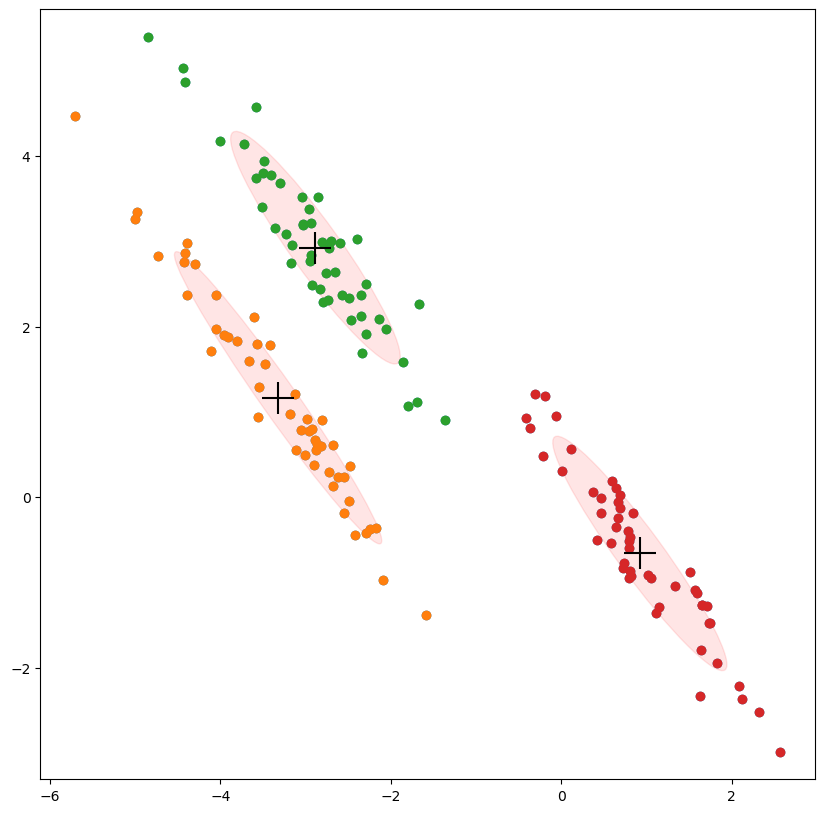

In [10]:
em_gmms = EM_GMMs(aniso, 3)
em_gmms.run(200)
em_gmms.assign_points()
em_gmms.plot_clusters()

In [11]:
em_gmms = EM_GMMs(aniso, 3)
em_gmms.cluster[0]['mean'] = np.array([-4.,2])
em_gmms.cluster[1]['mean'] = np.array([-2.,2])
em_gmms.cluster[2]['mean'] = np.array([1.,0.])
em_gmms.expectation()
assert np.allclose(em_gmms.soft_n, np.array([51.63128785, 48.90090076, 49.46781139]))
assert np.allclose(em_gmms.soft_assignment.sum(-1), 1)
assert np.isclose(em_gmms.soft_assignment.sum(), aniso.shape[0])
assert np.allclose(em_gmms.soft_assignment[-1], np.array([0.06556629, 0.93222667, 0.00220704]))

In [12]:
em_gmms = EM_GMMs(aniso, 3)
em_gmms.soft_assignment[:50] = np.array([1.,0,0])
em_gmms.soft_assignment[50:100] = np.array([0.,1.,0.])
em_gmms.soft_assignment[100:] = np.array([0.,0.,1.])
em_gmms.soft_n = em_gmms.soft_assignment.sum(0)
em_gmms.maximization()
assert np.allclose(em_gmms.cluster[0]['mean'], np.array([-1.53090501,  0.95978549]))
assert np.allclose(em_gmms.cluster[0]['cov'], np.array([[ 3.91743533, -2.65473801], [-2.65473801,  2.76236005]]))
assert np.isclose(em_gmms.cluster[0]['w'], 1/3)